<h2>Linear Regression Analysis of Murder Rate by US State</h2>

<h4>Input Variables</h4>

<ul>
<li>population density</li>
<li>household income</li>
<li>poverty rate</li>
<li>education</li>
<li>suicide rate</li>
<li>incarceration rate</li>
</ul>

<h4>Output Variable</h4>
<ul>
<li>murder rate</li>
</ul>

<a href="http://en.wikipedia.org/wiki/Gun_violence_in_the_United_States_by_state">Gun Violence in the US by State</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_income">List of US States by Income</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment">List of US States by Educational Attainment</a>

<a href="http://usatoday30.usatoday.com/news/health/2007-11-28-depression-suicide-numbers_N.htm">Depression Suicide Numbers</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_incarceration_rate">List of US States by Incarceration</a>

<a href="https://www.census.gov/statab/ranks/rank21.html">Violent Crimes per US State</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_poverty_rate">List of US States by Poverty Rate</a>

In [111]:
"""
All imports listed here.
"""
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [112]:
"""
Method for importing text data and concatenating into a single DataFrame.
"""
def load_data():
    guns = pd.read_csv("data/guns.csv")
    guns = guns[guns.state != 'District of Columbia']
    
    income = pd.read_csv('data/household_income_2010.txt')
    combined = guns.merge(income[['state', 'income']], on='state')
    
    education = pd.read_csv('data/education.csv')
    combined = combined.merge(education[['state', 'high_school', 'bachelors', 'advanced']], on='state')
    combined['no_high_school'] = 100. - combined['high_school']
    
    suicide = pd.read_csv('data/suicide.csv')
    combined = combined.merge(suicide[['state', 'suicide_rate']], on='state')
    
    incarceration = pd.read_csv('data/incarceration.csv')
    combined = combined.merge(incarceration[['state','incarceration_rate']], on='state')
    
    violence = pd.read_csv('data/violence.csv')
    combined = combined.merge(violence[['state','violent_crime_rate']], on='state')
    
    poverty = pd.read_csv('data/poverty.csv')
    combined = combined.merge(poverty[['state','poverty_rate']], on='state')
    
    return combined

combined = load_data()

In [113]:
"""
Primary columns to be used for data analysis including predicted variable and all features.
"""
primary_cols = ['murder_rate', 'population_density', 'high_school', 'suicide_rate', 'incarceration_rate', 'poverty_rate', 
                'income', 'gun_ownership']

In [114]:
combined[primary_cols].describe()

,murder_rate,population_density,high_school,suicide_rate,incarceration_rate,poverty_rate,income,gun_ownership
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,3.840000,196.479780,86.874000,12.47800,395.560000,12.142000,50594.240000,37.612000
std,1.881923,261.266788,3.411913,3.55954,146.081213,3.043567,8844.934931,13.364355
min,1.000000,1.264000,79.900000,6.00000,148.000000,5.600000,36646.000000,6.700000
25%,2.125000,44.612500,83.975000,10.65000,273.000000,10.025000,44783.500000,31.425000
50%,4.050000,100.335000,87.500000,11.90000,380.500000,11.700000,48290.000000,40.050000
75%,5.075000,214.425000,89.800000,14.35000,458.500000,14.475000,55213.750000,44.050000
max,9.600000,1189.000000,91.800000,23.10000,847.000000,20.100000,69860.000000,59.700000


In [115]:
print combined.columns
combined[primary_cols].corr()

Index([u'state', u'population', u'population_density', u'murders', u'gun_murders', u'gun_ownership', u'murder_rate', u'gun_murder_rate', u'income', u'high_school', u'bachelors', u'advanced', u'no_high_school', u'suicide_rate', u'incarceration_rate', u'violent_crime_rate', u'poverty_rate'], dtype='object')


,murder_rate,population_density,high_school,suicide_rate,incarceration_rate,poverty_rate,income,gun_ownership
murder_rate,1.000000,0.139420,-0.669136,-0.081453,0.655537,0.515520,-0.190506,-0.119836
population_density,0.139420,1.000000,-0.046725,-0.641630,-0.270220,-0.289172,0.496774,-0.739535
high_school,-0.669136,-0.046725,1.000000,0.115563,-0.626972,-0.766861,0.446929,0.015967
suicide_rate,-0.081453,-0.641630,0.115563,1.000000,0.203124,0.157947,-0.293510,0.662998
incarceration_rate,0.655537,-0.270220,-0.626972,0.203124,1.000000,0.657218,-0.530396,0.341129
poverty_rate,0.515520,-0.289172,-0.766861,0.157947,0.657218,1.000000,-0.704510,0.349344
income,-0.190506,0.496774,0.446929,-0.293510,-0.530396,-0.704510,1.000000,-0.560928
gun_ownership,-0.119836,-0.739535,0.015967,0.662998,0.341129,0.349344,-0.560928,1.000000


In [116]:
#sns.pairplot(combined[primary_cols])
#plt.savefig('corr.png')

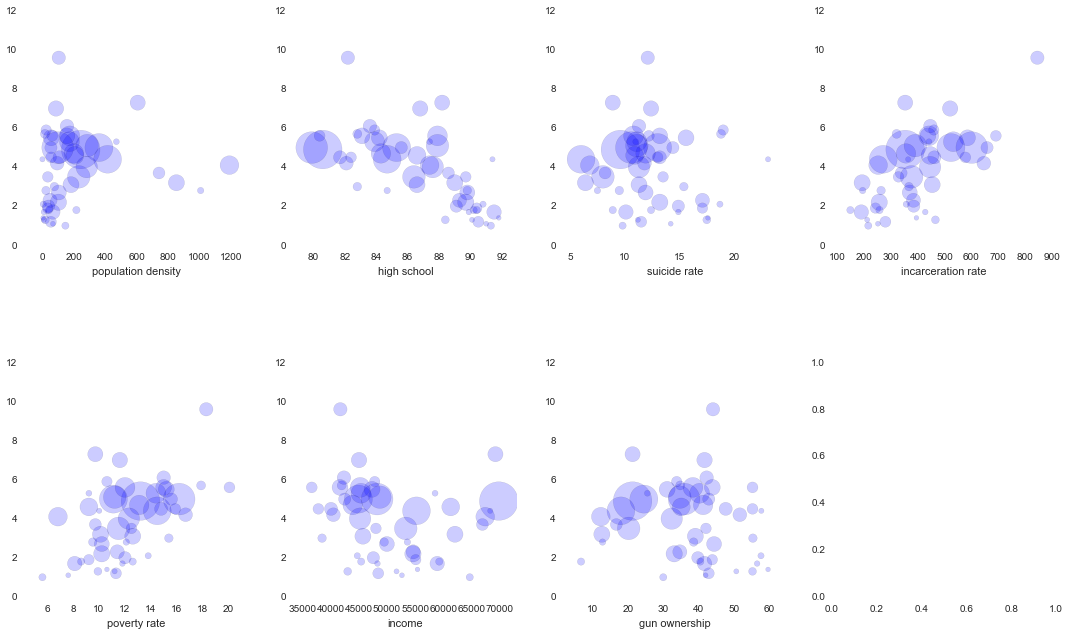

In [117]:
"""
Plot feature on X vs predicted variable on Y for all features of interest.
"""

f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)

f.set_size_inches(18.5, 10.5)

x_cols = ['population_density', 'high_school', 'suicide_rate', 
          'incarceration_rate', 'poverty_rate', 'income', 'gun_ownership']
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

def plot_ax(ax, x_col_name):
    
    ax.scatter(combined[x_col_name], combined["murder_rate"], s=combined['population']/25000., alpha=0.2)
    x_margin = (combined[x_col_name].max() - combined[x_col_name].min()) * 0.1  
    ax.set_xlim([combined[x_col_name].min() - x_margin, combined[x_col_name].max() + x_margin])
    ax.set_xlabel(x_col_name.replace("_", " "))
    ax.set_axis_bgcolor("white")
        
for a, x in zip(axes, x_cols):
    plot_ax(a, x)
    
ax8.set_axis_bgcolor("white")
    
f.subplots_adjust(hspace=0.5)

In [118]:
"""
Perform a linear fit of predicted variable vs a single feature and plot the result.
"""
def fit_lin(df, title, x_col_name, y_col_name="murder_rate"):
        
    # Get column data for plot
    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values
            
    # Create linear regression model and perform fit
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    
    print "residuals", regr.residues_
    print "Coefficients: \n", regr.coef_

    # The mean square error
    print("Residual sum of squares: %.2f" % np.mean((regr.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    print "intercept", regr.intercept_

    predicted = regr.predict(x)
    truth = df[y_col_name].values
    
    mse = mean_squared_error(truth, predicted)
    mae = mean_absolute_error(truth, predicted)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg="white")
    
    ax.grid(b=False)
    
    ax.scatter(x, y, color='blue', alpha=0.2, s=df['population']/25000.)
    ax.plot(x, regr.predict(x), color='red', linewidth=1, alpha=1.0)
    ax.annotate("Mean Sq Err = " + str(round(mse, 4)), xy=(0.7, 0.85), xycoords="figure fraction")
    ax.annotate("Mean Ab Err = " + str(round(mae, 4)), xy=(0.7, 0.8), xycoords="figure fraction")
    ax.annotate("Var Score = " + str(round(regr.score(x, y), 4)), xy=(0.7, 0.75), xycoords="figure fraction")
    
    ax.set_xlabel(x_col_name.replace('_', ' '), fontsize=12)
    ax.set_ylabel(y_col_name.replace('_', ' '), fontsize=12)
    
    ax.set_title(title, fontsize=20)
        
    plt.show()

In [119]:
"""
Perform a polynomial fit of degree 4 using a single feature (function is currently unused).
"""
def fit_poly(df, title, x_col_name, y_col_name="murder_rate", degree=4):

    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values.reshape(-1,1)
    
    degree = 4
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(x, y)
    
    predicted = est.predict(x)
    truth = df["murder_rate"].values
    
    mse = mean_squared_error(truth, predicted)
    mae = mean_absolute_error(truth, predicted)
    
    x_min = df[x_col_name].min()
    x_max = df[x_col_name].max() 
    x_plot = np.linspace(x_min, x_max, 100)
            
    plt.axes().grid(b=False)
    plt.axes(axisbg='white')    
    
    plt.scatter(x, y, s=df['population']/25000, alpha=0.25)
    plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red')
    
    ax.annotate("Mean Sq Err = " + str(round(mse, 4)), xy=(0.7, 0.8), xycoords="figure fraction")
    ax.annotate("Mean Ab Err = " + str(round(mae, 4)), xy=(0.7, 0.85), xycoords="figure fraction")
    
    plt.suptitle(title, fontsize=20)
    plt.xlabel(x_col_name.replace('_', ' '), fontsize=12)
    plt.ylabel(y_col_name.replace('_', ' '), fontsize=12)
    plt.show()

In [120]:
# OLS fit
def fit_ols(df, x_col_name, y_col_name="murder_rate"):
    ols_fit = smf.ols(y_col_name + ' ~ ' + x_col_name, data=df).fit()
    print ols_fit.pvalues
    print ols_fit.summary()

In [121]:
"""
Perform a polynomial fit of degree 3 with LASSO (L1-norm) constraint of coefficients.
"""
def fit_lasso(df, title, x_col_name, y_col_name="murder_rate", degree=3, alpha=1e-3):
    
    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values.reshape(-1,1)
    
    degree = 4
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=1000))
    est.fit(x, y)
    
    predicted = est.predict(x)
    truth = df[y_col_name].values
    
    mse = mean_squared_error(truth, predicted)
    mae = mean_absolute_error(truth, predicted)
        
    x_min = df[x_col_name].min()
    x_max = df[x_col_name].max()
    x_plot = np.linspace(x_min, x_max, 100)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg="white")
    
    ax.grid(b=False)
    
    ax.scatter(x, y, s=df['population']/25000, alpha=0.25)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red')
    
    ax.annotate("Mean Sq Err = " + str(round(mse, 4)), xy=(0.7, 0.85), xycoords="figure fraction")
    ax.annotate("Mean Ab Err = " + str(round(mae, 4)), xy=(0.7, 0.8), xycoords="figure fraction")
    ax.annotate("Var Score = " + str(round(est.score(x, y), 4)), xy=(0.7, 0.75), xycoords="figure fraction")
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_col_name.replace('_', ' '), fontsize=12)
    ax.set_ylabel(x_col_name.replace('_', ' '), fontsize=12)

    plt.show()

residuals 170.166762326
Coefficients: 
[ 0.00100425]
Residual sum of squares: 3.40
Variance score: 0.02
intercept 3.64268546025


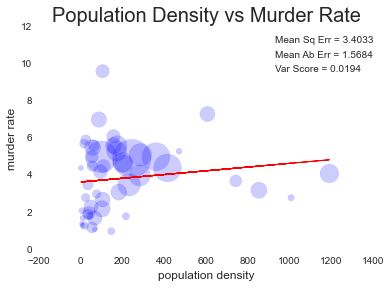

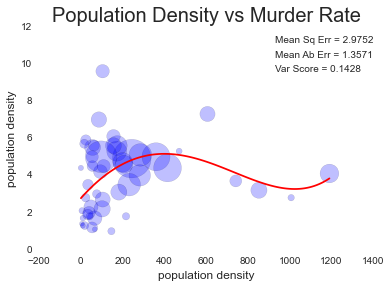

In [122]:
#fit_ols(combined, 'population_density')
fit_lin(combined, 'Population Density vs Murder Rate', 'population_density')
#fit_poly(combined, 'Population Density vs Murder Rate', 'population_density')
fit_lasso(combined, 'Population Density vs Murder Rate', 'population_density')

In [123]:
#fit_lin(combined, 'Income vs Murder Rate', 'income')
#fit_poly(combined, 'Income vs Murder Rate', 'income')
#fit_lasso(combined, 'Income vs Murder Rate', 'income')

residuals 127.419807051
Coefficients: 
[ 0.31876058]
Residual sum of squares: 2.55
Variance score: 0.27
intercept -0.0303909347793


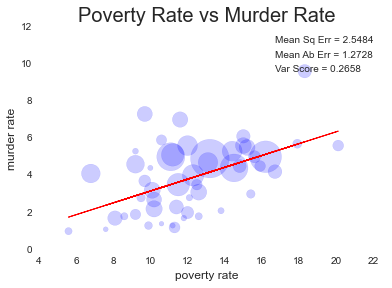

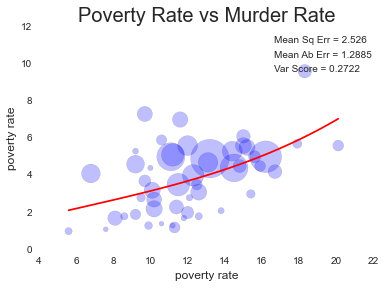

In [124]:
fit_lin(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')
#fit_poly(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')
fit_lasso(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')

residuals 95.8387727487
Coefficients: 
[-0.36907788]
Residual sum of squares: 1.92
Variance score: 0.45
intercept 35.9032714709


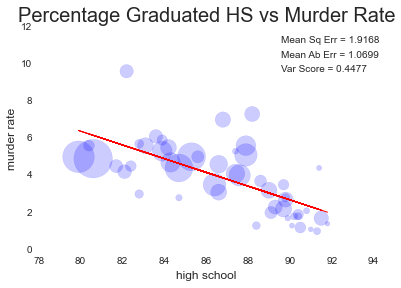

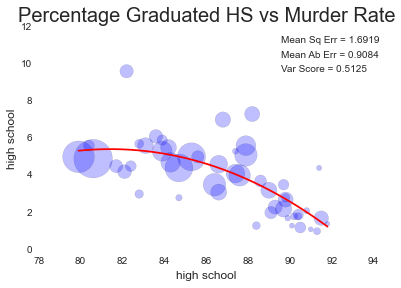

In [125]:
fit_lin(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')
#fit_poly(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')
fit_lasso(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')

residuals 98.964934182
Coefficients: 
[ 0.00844509]
Residual sum of squares: 1.98
Variance score: 0.43
intercept 0.49945917086


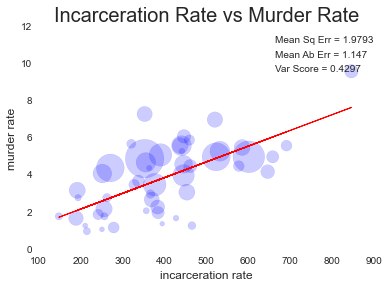

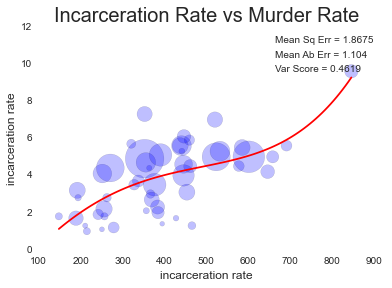

In [126]:
fit_lin(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')
#plt.savefig('incarceration.png')
#fit_poly(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')
fit_lasso(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')

residuals 172.388645354
Coefficients: 
[-0.04306383]
Residual sum of squares: 3.45
Variance score: 0.01
intercept 4.37735051119


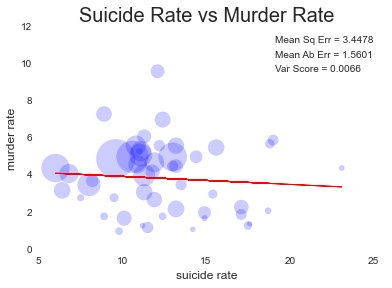

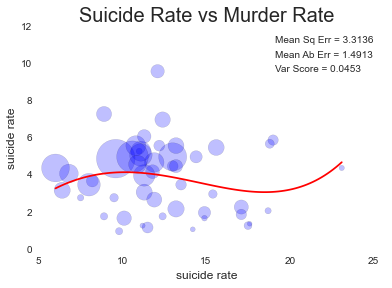

In [127]:
fit_lin(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')
#fit_poly(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')
fit_lasso(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')

residuals 171.04784627
Coefficients: 
[-0.01687491]
Residual sum of squares: 3.42
Variance score: 0.01
intercept 4.47469899309


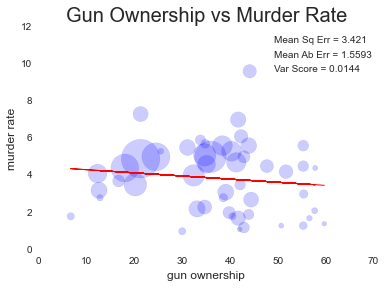

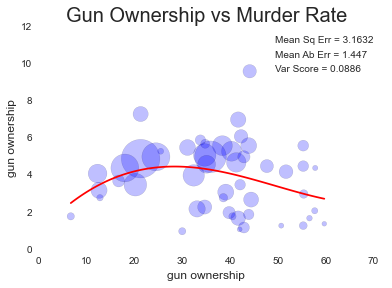

In [128]:
fit_lin(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')
#fit_poly(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')
fit_lasso(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')

residuals 95.8387727487
Coefficients: 
[ 0.36907788]
Residual sum of squares: 1.92
Variance score: 0.45
intercept -1.00451621115


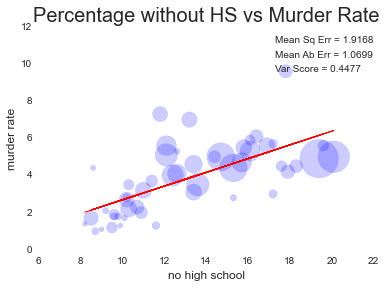

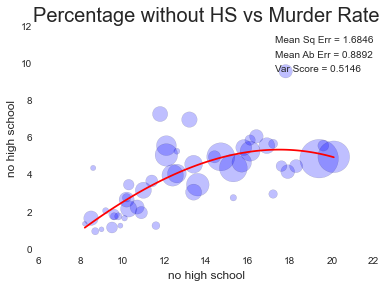

In [129]:
fit_lin(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')
#fit_poly(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')
fit_lasso(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')

residuals 60.5646129456
Coefficients: 
[ 0.00825364]
Residual sum of squares: 1.21
Variance score: 0.65
intercept 0.455345572578


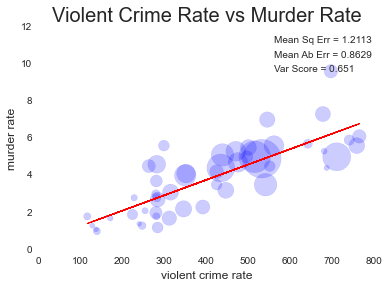

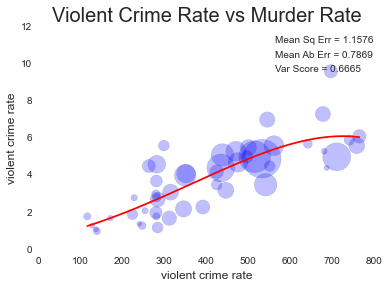

In [130]:
fit_lin(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')
#fit_poly(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')
fit_lasso(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')

In [131]:
# sum(actual_value - mean)^2) / total_n